## Loading Libraries and Data

In [172]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [173]:
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

# train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
# test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')

sample = pd.read_csv('sample_submission.csv')

In [174]:
print(train_transaction.shape,test_transaction.shape)
# print(train_id.shape, test_id.shape)
print(sample.shape)

(590540, 394) (506691, 393)
(506691, 2)


1. Size of both train and test data is comparable. 
2. Number of features is pretty high.

## DATA PREPROCESSING

In [175]:
train_transaction.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
train_transaction.info(max_cols=400)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 394 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   isFraud         590540 non-null  int64  
 2   TransactionDT   590540 non-null  int64  
 3   TransactionAmt  590540 non-null  float64
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int64  
 6   card2           581607 non-null  float64
 7   card3           588975 non-null  float64
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float64
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float64
 12  addr2           524834 non-null  float64
 13  dist1           238269 non-null  float64
 14  dist2           37627 non-null   float64
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
 17  C1       

There are many columns with large number of missing values.
We can drop columns with more than 50% missing values.

In [177]:
columns_to_drop = []
num_of_rows = train_transaction.shape[0]
for i in train_transaction.columns:
    count_of_null_values = train_transaction[i].isna().sum()
    if (count_of_null_values >= num_of_rows/2):
        columns_to_drop.append(i)
del num_of_rows        

In [178]:
# Dropping columns with more than 50% missing values.
train_transaction.drop(columns_to_drop, axis=1, inplace=True)
test_transaction.drop(columns_to_drop, axis=1, inplace=True)

print("No of columns dropped {}".format(len(columns_to_drop)))
del columns_to_drop
gc.collect()

No of columns dropped 174


65

Let's preprocess the object type columns first.

In [179]:
object_columns = train_transaction.select_dtypes(include=object).columns
print("Number of categorical columns: {}".format(len(object_columns)))

Number of categorical columns: 9


In [180]:
for i in object_columns:
    print("Column Name : {}".format(i))
    print("-------------> No of missing values: {}".format(train_transaction[i].isna().sum()))
    print("-------------> Unique values: {}".format(train_transaction[i].unique()))

Column Name : ProductCD
-------------> No of missing values: 0
-------------> Unique values: ['W' 'H' 'C' 'S' 'R']
Column Name : card4
-------------> No of missing values: 1577
-------------> Unique values: ['discover' 'mastercard' 'visa' 'american express' nan]
Column Name : card6
-------------> No of missing values: 1571
-------------> Unique values: ['credit' 'debit' nan 'debit or credit' 'charge card']
Column Name : P_emaildomain
-------------> No of missing values: 94456
-------------> Unique values: [nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de

Some insights:
1. Categorical columns with no missing values : ProductCD
2. Categorical columns with few missing values : card4,card6
3. Categorical columns with many missing values : P_emaildomain, M6
4. Categorical columns with huge number of missing values : M1,M2,M3,M4

Lets plot the value counts graphs for these columns and see if we can fill the missing values with the mode value.

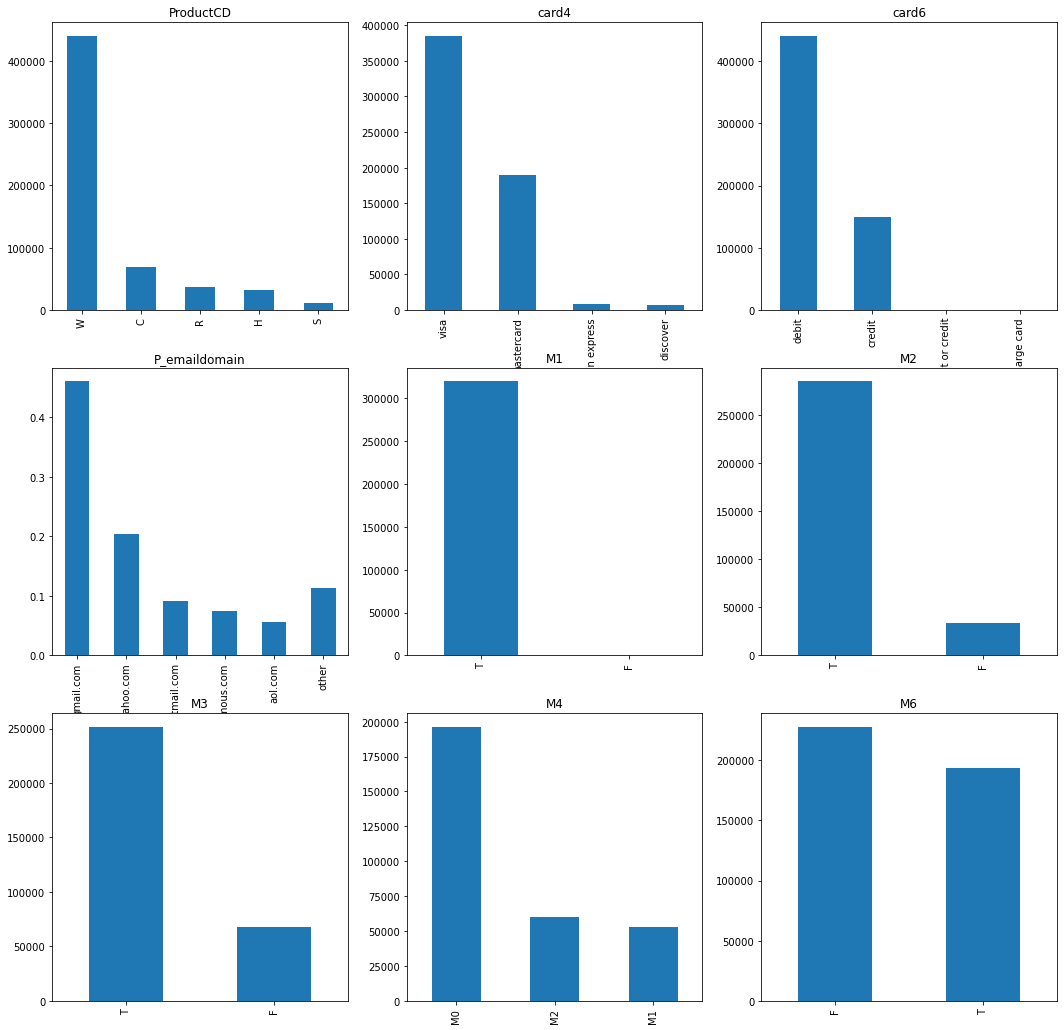

In [181]:
fig,ax = plt.subplots(3,3,figsize=(18,18))
for k,i in enumerate(object_columns):
    plt.subplot(3,3,k+1)
    if(i != 'P_emaildomain'):
        train_transaction[i].value_counts().plot(kind='bar')
    else:
        prob = train_transaction[i].value_counts(normalize=True)
        threshold = 0.02
        mask = prob > threshold
        tail_prob = prob.loc[~mask].sum()
        prob = prob.loc[mask]
        prob['other'] = tail_prob
        prob.plot(kind='bar')
    plt.title(i)

There are many interesting things here,
1. 'W' is the ProductCD in over 400,000 transactions.
2. card4 type is 'visa' in over 350,000 transactions and 'mastercard' in 200,000 transactions. Other types are rare.
3. card6 value is 'debit' in approx. 430,000 transactions and 'credit' in approx. 150,000 transactions. Other values are extremely rare.
4. P_emaildomain type in 'google.com' in over 40% of the transactions and 'yahoo.com' in 20% of the transactions. Some values are comparatively less. Most values are rare.
5. For M2 and M3, 'T' is the category for most transactions.
6. For M1, 'F' category is extremely rare.
7. In case of M4, 'M0' is the most occurred value.
8. In M6, both 'T' and 'F' occur almost equally. Still, we will fill the missing values with 'F' as it is the mode.

From these insights, we can safely fill the missing values with the mode of the object columns.

Now, plotting the object columns from test transactions.

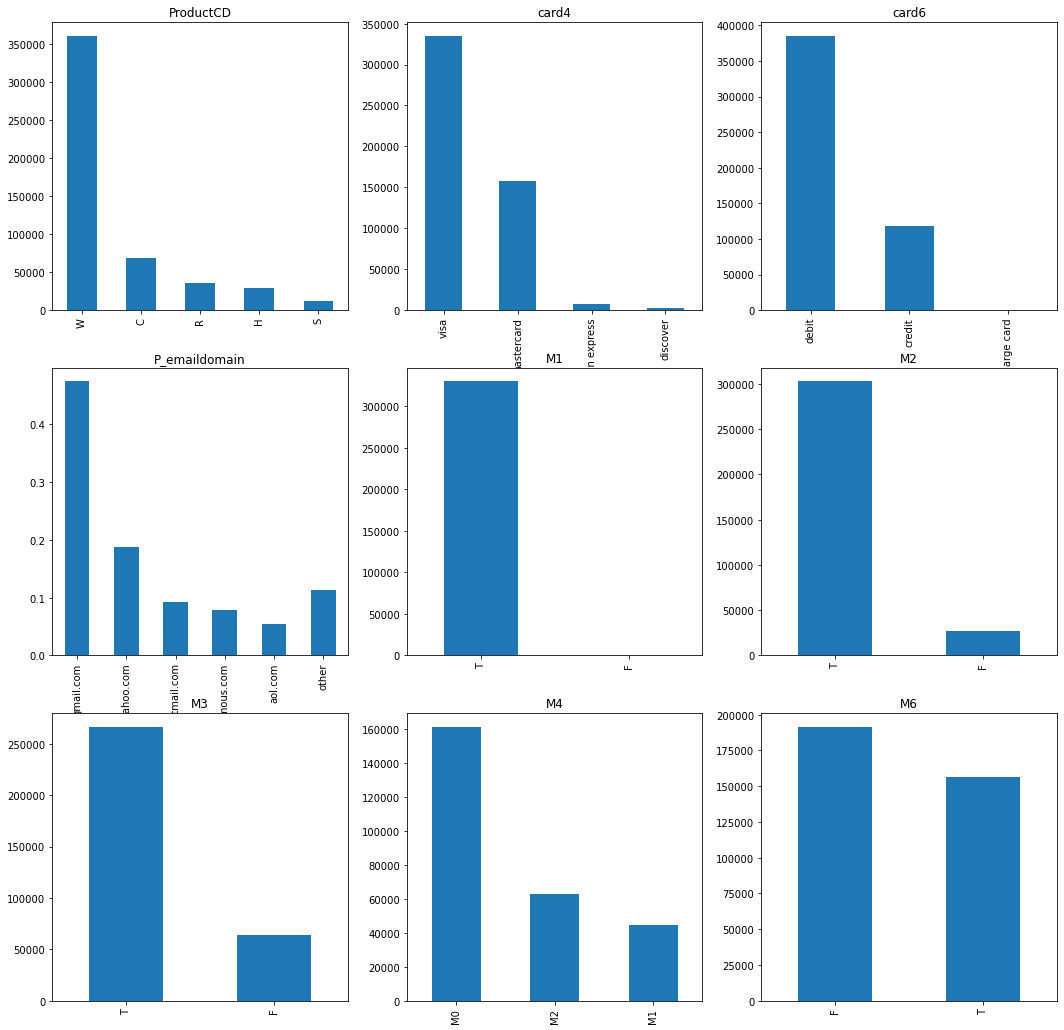

In [182]:
fig,ax = plt.subplots(3,3,figsize=(18,18))
for k,i in enumerate(object_columns):
    plt.subplot(3,3,k+1)
    if(i != 'P_emaildomain'):
        test_transaction[i].value_counts().plot(kind='bar')
    else:
        prob = test_transaction[i].value_counts(normalize=True)
        threshold = 0.02
        mask = prob > threshold
        tail_prob = prob.loc[~mask].sum()
        prob = prob.loc[mask]
        prob['other'] = tail_prob
        prob.plot(kind='bar')
    plt.title(i)

Above insights hold true for test data too.

In [183]:
for i in object_columns:
    train_transaction[i].fillna(train_transaction[i].mode()[0], inplace=True)
    test_transaction[i].fillna(test_transaction[i].mode()[0], inplace=True)

Now, let's see categorical features with numeric values.
[From the competition host](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)

In [184]:
# Categorical Features:
# ProductCD
# card1 - card6
# addr1, addr2
# Pemaildomain Remaildomain
# M1 - M9

# We handles few M* features above, others were dropped because of >50% missing values.
cat_num_features = ['addr1','addr2', 'card1', 'card2', 'card3', 'card5']


In [185]:
for i in cat_num_features:
    print("Column Name : {}".format(i))
    print("-------------> No of missing values: {}".format(train_transaction[i].isna().sum()))
    print("Mode value {} occurred in {} transactions \n".format(train_transaction[i].mode()[0], train_transaction[i].value_counts().values[0]))

Column Name : addr1
-------------> No of missing values: 65706
Mode value 299.0 occurred in 46335 transactions 

Column Name : addr2
-------------> No of missing values: 65706
Mode value 87.0 occurred in 520481 transactions 

Column Name : card1
-------------> No of missing values: 0
Mode value 7919 occurred in 14932 transactions 

Column Name : card2
-------------> No of missing values: 8933
Mode value 321.0 occurred in 48935 transactions 

Column Name : card3
-------------> No of missing values: 1565
Mode value 150.0 occurred in 521287 transactions 

Column Name : card5
-------------> No of missing values: 4259
Mode value 226.0 occurred in 296546 transactions 



In [186]:
# Filling the missing values with mode.
for i in cat_num_features:
    train_transaction[i].fillna(train_transaction[i].mode()[0], inplace=True)
    test_transaction[i].fillna(test_transaction[i].mode()[0], inplace=True)
del cat_num_features
gc.collect()

117

Now let's create a list of numerical features with missing values.

In [187]:
all_numeric_columns = train_transaction.select_dtypes(include=np.number).columns
numeric_missing = []
for i in all_numeric_columns:
    missing = train_transaction[i].isna().sum()
    if(missing>0):
        numeric_missing.append(i)
del all_numeric_columns        
print(len(numeric_missing))

187


In [188]:
train_transaction[numeric_missing].describe()

,D1,D2,D3,D4,D10,D11,D15,V1,V2,V3,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,589271.000000,309743.000000,327662.000000,421618.000000,514518.000000,311253.000000,501427.000000,311253.000000,311253.000000,311253.000000,...,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000
mean,94.347568,169.563231,28.343348,140.002441,123.982137,146.621465,163.744579,0.999945,1.045204,1.078075,...,39.173910,21.351473,43.319174,26.806977,109.818544,247.606741,162.153398,18.372476,42.073133,28.326584
std,157.660387,177.315865,62.384721,191.096774,182.615225,186.042622,202.726660,0.007390,0.240133,0.320890,...,172.128339,95.902970,173.619028,116.853222,2270.033202,3980.042828,2793.343636,332.304848,473.499307,382.053171
min,0.000000,0.000000,0.000000,-122.000000,0.000000,-53.000000,-83.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,26.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,97.000000,8.000000,26.000000,15.000000,43.000000,52.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,122.000000,276.000000,27.000000,253.000000,197.000000,274.000000,314.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,640.000000,640.000000,819.000000,869.000000,876.000000,670.000000,879.000000,1.000000,8.000000,9.000000,...,55125.000000,4817.470215,7519.870117,4817.470215,93736.000000,134021.000000,98476.000000,104060.000000,104060.000000,104060.000000


Here were can see that for most V_ columns, median and mode values are same.

In [189]:
for k,i in enumerate(numeric_missing):
    print(k)
    print("Column {} has {} missing values".format(i, train_transaction[i].isna().sum()))
    print("Mode value {} occurred in {} transactions".format(train_transaction[i].mode()[0], train_transaction[i].value_counts().values[0]))
    print("Median value {} \n".format(train_transaction[i].median(), train_transaction[i].value_counts().values[0]))

0
Column D1 has 1269 missing values
Mode value 0.0 occurred in 280130 transactions
Median value 3.0 

1
Column D2 has 280797 missing values
Mode value 0.0 occurred in 15124 transactions
Median value 97.0 

2
Column D3 has 262878 missing values
Mode value 0.0 occurred in 73094 transactions
Median value 8.0 

3
Column D4 has 168922 missing values
Mode value 0.0 occurred in 166571 transactions
Median value 26.0 

4
Column D10 has 76022 missing values
Mode value 0.0 occurred in 221930 transactions
Median value 15.0 

5
Column D11 has 279287 missing values
Mode value 0.0 occurred in 112281 transactions
Median value 43.0 

6
Column D15 has 89113 missing values
Mode value 0.0 occurred in 174246 transactions
Median value 52.0 

7
Column V1 has 279287 missing values
Mode value 1.0 occurred in 311236 transactions
Median value 1.0 

8
Column V2 has 279287 missing values
Mode value 1.0 occurred in 298894 transactions
Median value 1.0 

9
Column V3 has 279287 missing values
Mode value 1.0 occurred 

Median value 0.0 

80
Column V74 has 77096 missing values
Mode value 0.0 occurred in 440878 transactions
Median value 0.0 

81
Column V75 has 89164 missing values
Mode value 1.0 occurred in 265082 transactions
Median value 1.0 

82
Column V76 has 89164 missing values
Mode value 1.0 occurred in 273293 transactions
Median value 1.0 

83
Column V77 has 89164 missing values
Mode value 1.0 occurred in 474434 transactions
Median value 1.0 

84
Column V78 has 89164 missing values
Mode value 1.0 occurred in 457915 transactions
Median value 1.0 

85
Column V79 has 89164 missing values
Mode value 0.0 occurred in 436802 transactions
Median value 0.0 

86
Column V80 has 89164 missing values
Mode value 0.0 occurred in 434732 transactions
Median value 0.0 

87
Column V81 has 89164 missing values
Mode value 0.0 occurred in 434653 transactions
Median value 0.0 

88
Column V82 has 89164 missing values
Mode value 1.0 occurred in 402612 transactions
Median value 1.0 

89
Column V83 has 89164 missing valu

Column V293 has 12 missing values
Mode value 0.0 occurred in 546442 transactions
Median value 0.0 

159
Column V294 has 12 missing values
Mode value 0.0 occurred in 519413 transactions
Median value 0.0 

160
Column V295 has 12 missing values
Mode value 0.0 occurred in 535074 transactions
Median value 0.0 

161
Column V296 has 1269 missing values
Mode value 0.0 occurred in 536687 transactions
Median value 0.0 

162
Column V297 has 12 missing values
Mode value 0.0 occurred in 562740 transactions
Median value 0.0 

163
Column V298 has 12 missing values
Mode value 0.0 occurred in 542892 transactions
Median value 0.0 

164
Column V299 has 12 missing values
Mode value 0.0 occurred in 555629 transactions
Median value 0.0 

165
Column V300 has 1269 missing values
Mode value 0.0 occurred in 569522 transactions
Median value 0.0 

166
Column V301 has 1269 missing values
Mode value 0.0 occurred in 567409 transactions
Median value 0.0 

167
Column V302 has 12 missing values
Mode value 0.0 occurred 

In [190]:
# Filling the missing values with median.
for i in numeric_missing:
    train_transaction[i].fillna(train_transaction[i].median(), inplace=True)
    test_transaction[i].fillna(test_transaction[i].median(), inplace=True)
print(train_transaction.isna().any().sum(), test_transaction.isna().any().sum())   
del numeric_missing
gc.collect()

0 14


0

Now, there are no missing values in our data. Let's start with handling categorical features.

In [191]:
# object_columns
for f in object_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train_transaction[f].values) + list(test_transaction[f].values))
    train_transaction[f] = lbl.transform(list(train_transaction[f].values))
    test_transaction[f] = lbl.transform(list(test_transaction[f].values))    

In [192]:
train_transaction[object_columns].head()


,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6
0,4,1,1,16,1,1,1,2,1
1,4,2,1,16,1,1,1,0,1
2,4,3,2,35,1,1,1,0,0
3,4,2,2,54,1,1,1,0,0
4,1,2,1,16,1,1,1,0,0


In [193]:
test_transaction[object_columns].head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6
0,4,3,2,16,1,1,0,0,0
1,4,3,2,2,1,0,0,0,0
2,4,3,2,19,1,1,0,0,0
3,4,3,2,16,1,1,1,0,1
4,4,2,2,16,1,1,1,0,0


In [194]:
len(train_transaction.select_dtypes(exclude=np.number).sum())
del object_columns
gc.collect()

80

Now, all columns in the data have numeric values.

## EDA

Now that our data contains no missing values and no categorical values. We can start plotting some graphs to get intuition about the data. 

In [195]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,4,13926,321.0,150.0,1,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,4,4663,490.0,150.0,3,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
train_transaction.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,3.220757,9898.734658,361.926886,153.186458,2.614754,199.471611,...,39.173114,21.305592,43.226087,26.749372,109.816313,247.601710,162.150103,18.372102,42.072278,28.326009
std,1.704744e+05,0.183755,4.617224e+06,239.162522,1.423926,4901.170153,156.677363,11.322604,0.586491,41.157610,...,172.126681,95.804974,173.443984,116.734202,2270.010192,3980.002546,2793.315350,332.301482,473.494534,382.049311
min,2.987000e+06,0.000000,8.640000e+04,0.251000,0.000000,1000.000000,100.000000,100.000000,0.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,3.000000,6019.000000,215.000000,150.000000,2.000000,166.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,4.000000,9678.000000,360.000000,150.000000,3.000000,226.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,4.000000,14184.000000,512.000000,150.000000,3.000000,226.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,4.000000,18396.000000,600.000000,231.000000,3.000000,237.000000,...,55125.000000,4817.470215,7519.870117,4817.470215,93736.000000,134021.000000,98476.000000,104060.000000,104060.000000,104060.000000


Here,
1. Mean of the 'isFraud' column is 0.034, this tells us that the no. of 0s in the columns is way greater than the number of 1s.
2. In most of V_ columns, the max value is way greater than the mean and median. Outliers are present.


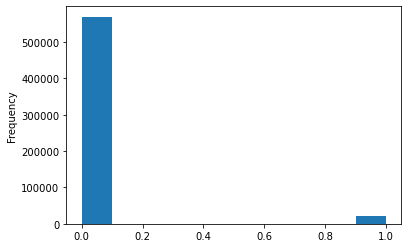

In [197]:
# Let's plot the histogram of isFraud column.
train_transaction['isFraud'].plot(kind='hist')

The data is highly imbalanced. We can downsample the '0' class or upsample '1' class, but for now let's continue with the imbalanced data and check the score.

Number of features is over 200, we can't plot pairplots or heatmaps, It will take up all of kernel's ram. Let's skip to training and get a baseline score.

In [198]:
# X_train,X_val,y_train,y_val = train_test_split(train_transaction.drop(['isFraud'],axis=1), train_transaction['isFraud'], test_size=0.2)

In [199]:
train_transaction.to_csv("train_transaction.csv",sep= ',',index=False)

In [200]:
test_transaction.to_csv("test_transaction.csv",sep= ',',index=False)

In [201]:
#train_transaction = train_transaction.loc[:, train_transaction.ge(0).all()]

In [202]:
Y_train = train_transaction['isFraud']

In [203]:
Y_train.shape

(590540,)

In [204]:
X_train = train_transaction.drop(['isFraud'],axis=1)

In [205]:
X_train.shape


(590540, 219)

In [206]:
X_test = test_transaction
#train_transaction

In [207]:
X_test.shape


(506691, 219)

I prefer manual tuning for the baseline model, you can use Hyperopt for hyperparamer-tuning.

In [ ]:
# Score= .7427
params = {
    'objective': 'binary',
    'n_estimators':300,
    'learning_rate': 0.1,
    'subsample':0.8
}
# Score= .7306
params1 = {
    'objective': 'binary',
    'n_estimators': 200,
    'learning_rate': 0.1,
}
#Score= .7446
params2 = {
    'objective': 'binary',
    'n_estimators':300,
    'learning_rate': 0.1,
}
# Score=.774
params3 = {
    'objective': 'binary',
    'n_estimators':600,
    'learning_rate': 0.1
}
#Score= .7666
params4 = {
    'objective': 'binary',
    'n_estimators':500,
    'learning_rate': 0.1
}
#Score= .7711
params5 = {
    'objective': 'binary',
    'n_estimators':500,
    'learning_rate': 0.1,
    'num_leaves' : 50,
    'max_depth' : 7,
    'subsample' : 0.9,
    'colsample_bytree' : 0.9
}
#Score=.78109
params6 = {
    'objective': 'binary',
    'n_estimators':600,
    'learning_rate': 0.1,
    'num_leaves' : 50,
    'max_depth' : 7,
    'subsample' : 0.9,
    'colsample_bytree' : 0.9
}
#Score=.7863
params7 = {
    'objective': 'binary',
    'n_estimators':700,
    'learning_rate': 0.1,
    'num_leaves' : 50,
    'max_depth' : 7,
    'subsample' : 0.9,
    'colsample_bytree' : 0.9
}

In [ ]:
clf = LGBMClassifier(**params7, random_state=108)
clf.fit(X_train,Y_train)

In [ ]:
# preds = clf.predict(X_val)
# roc_auc_score(y_val, preds)

In [ ]:
predictions = clf.predict_proba(X_test)
sample['isFraud'] = predictions[:,1]
sample.to_csv('submission_lgbm.csv', index=False)

In [ ]:
# from sklearn.svm import SVC


In [ ]:
# svm_clf = SVC(kernel='linear', random_state = 1)


In [ ]:
# svm_clf

In [ ]:
# svm_clf.fit(X_train,Y_train)


Code below can be used to download the .csv generated in your Kaggle kernel, this way you can submit the predictions without having to commit the kernel again and again. ![Thanks to Rachel](https://www.kaggle.com/rtatman/download-a-csv-file-from-a-kernel)

In [ ]:
# def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
#     csv = df.to_csv(index=False)
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)
# create_download_link(sample)

In [ ]:
# train_transaction = pd.read_csv('../input/cleandata/train_transaction.csv')
# test_transaction = pd.read_csv('../input/cleandata/test_transaction.csv')

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000,random_state=121,min_samples_split = 2, bootstrap = False, max_depth = 5)


In [ ]:
rf

In [ ]:
rf.fit(X_train,Y_train)


In [214]:
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)


In [215]:
X_test.fillna(999, inplace=True)


In [ ]:
predictions = rf.predict_proba(X_test)


In [ ]:
sample = pd.read_csv('sample_submission.csv')

In [ ]:
predictions[:,1]

In [ ]:
sample['isFraud'] = predictions[:,1]
sample.to_csv('submission_rf.csv', index=False)

In [ ]:
from sklearn import tree


In [ ]:
DTree = tree.DecisionTreeClassifier(random_state=0, criterion='entropy',max_depth=8,splitter='best', min_samples_split=30)

In [ ]:
DTree = DTree.fit(X_train,Y_train)

In [ ]:
pred = DTree.predict(X_train)


In [ ]:
pred

In [ ]:
sample['isFraud'] = predictions
sample.to_csv('submission_dt.csv', index=False)

In [56]:
#X_train[ (X_train  <0 ) ] = 0

In [59]:
X_test.fillna(999, inplace=True)


In [85]:
from sklearn.naive_bayes import  BernoulliNB,MultinomialNB,GaussianNB

clf = BernoulliNB()
model = clf.fit(X_train,Y_train)

In [86]:
pred = model.predict(X_test)

In [87]:
pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [90]:
sample['isFraud'] = pred
sample.to_csv('submission_bnb.csv', index=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

## REFERENCES

1. I haven't seen any kernels from this competition yet, but I would like to thank artgor for his amazing EDA kernels. I have done a basic analysis of some of his kernels and learned a lot from them.

If you think there are mistakes or improvements can be made, please comment :)

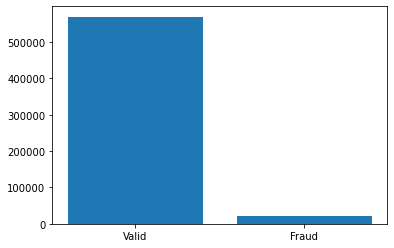

In [216]:
labels = ['Valid','Fraud']

plt.bar(labels,Y_train.value_counts())
plt.show()

In [217]:
#doing smote analysis here

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, Y_train)

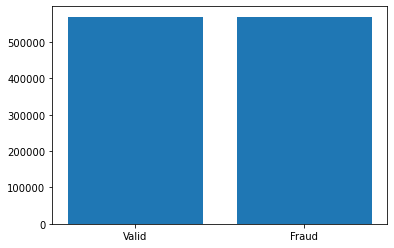

In [218]:
labels = ['Valid','Fraud']

plt.bar(labels,y_sm.value_counts())
plt.show()

In [93]:
clf = BernoulliNB()
model = clf.fit(X_sm,y_sm)

pred = model.predict(X_test)

In [96]:
'''
clf = GaussianNB()
model = clf.fit(X_sm,y_sm)

pred = model.predict(X_test)
'''

In [100]:
#X_sm = X_sm.loc[:, X_sm.ge(0).all()]

In [105]:
X_sm.shape

(838474, 202)

In [106]:
y_sm.shape

(838474,)

In [117]:
#test_transaction = test_transaction.loc[:, test_transaction.ge(0).all()]

In [120]:
#X_test = test_transaction

#X_test.shape

(506691, 204)

In [121]:
#cols = X_sm.columns

In [123]:
#X_test = X_test[cols]
#X_test.shape

(506691, 202)

In [226]:
#implementing XGB boost here
import xgboost as xgb

clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        #tree_method='gpu_hist' 
    )

In [ ]:
model = clf.fit(X_sm,y_sm)

pred = model.predict(X_test)

In [ ]:
sample['isFraud'] = pred
sample.to_csv('submission_xgb_boost.csv', index=False)

In [219]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [220]:

#kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
param_grid = {
                "alpha":[0.001,0.01,0.1,1],
    "fit_prior":[True]}                 

grid_tree = GridSearchCV(BernoulliNB(),param_grid,cv=10,return_train_score=True,n_jobs=-1)

model = grid_tree.fit(X_sm,y_sm)

In [221]:
pred = grid_tree.predict(X_test)

In [222]:
sample['isFraud'] = pred
sample.to_csv('submission_bnb_after_grid_after_k.csv', index=False)

In [78]:
#code for feature selection is done here:

#from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import RFECV



In [80]:
'''
percent = 25 # percent of dataset to use for feature selection

x_train_train, x_train_valid, y_train_train, y_train_valid = train_test_split(X_sm, y_sm, test_size=1.0-percent/100.0, random_state=42)

'''

In [82]:
'''
feature_selector = RFECV(BernoulliNB(), step=15, scoring='roc_auc', cv=5, verbose=1,n_jobs=3)
feature_selector.fit(x_train_train, y_train_train)
print('Features selected:', feature_selector.n_features_)

'''

Features selected: 219


In [84]:
'''
selected_features = [f for f in x_train_train.columns[feature_selector.ranking_ == 1]]

selected_features

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D10',
 'D11',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V8

In [85]:
#X_sm = X_sm[selected_feature]

In [87]:
#len([*X_test.columns])

219

In [88]:
#Note that the paramteres are the same and are confirmed
#from sklearn.svm import SVC

In [90]:
#svm_clf = SVC(C=1000, kernel="linear", probability=True, gamma = 0.0001, random_state=108, decision_function_shape='ovo')